Генерация графиков с исправленным кодом:


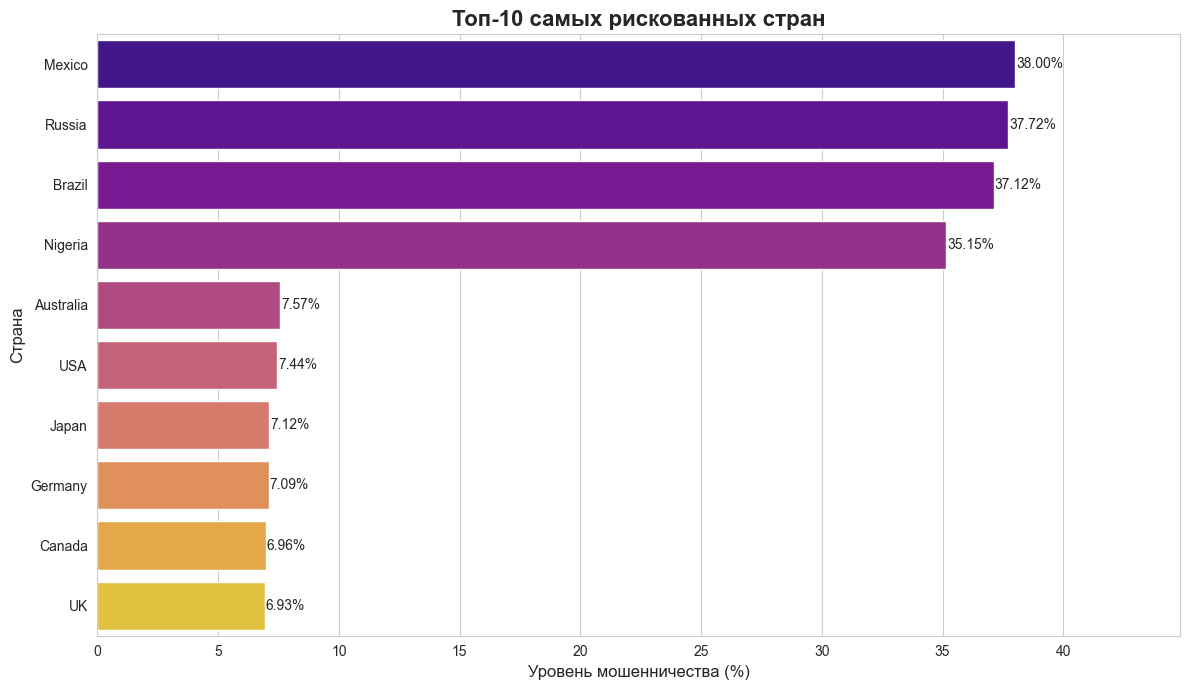

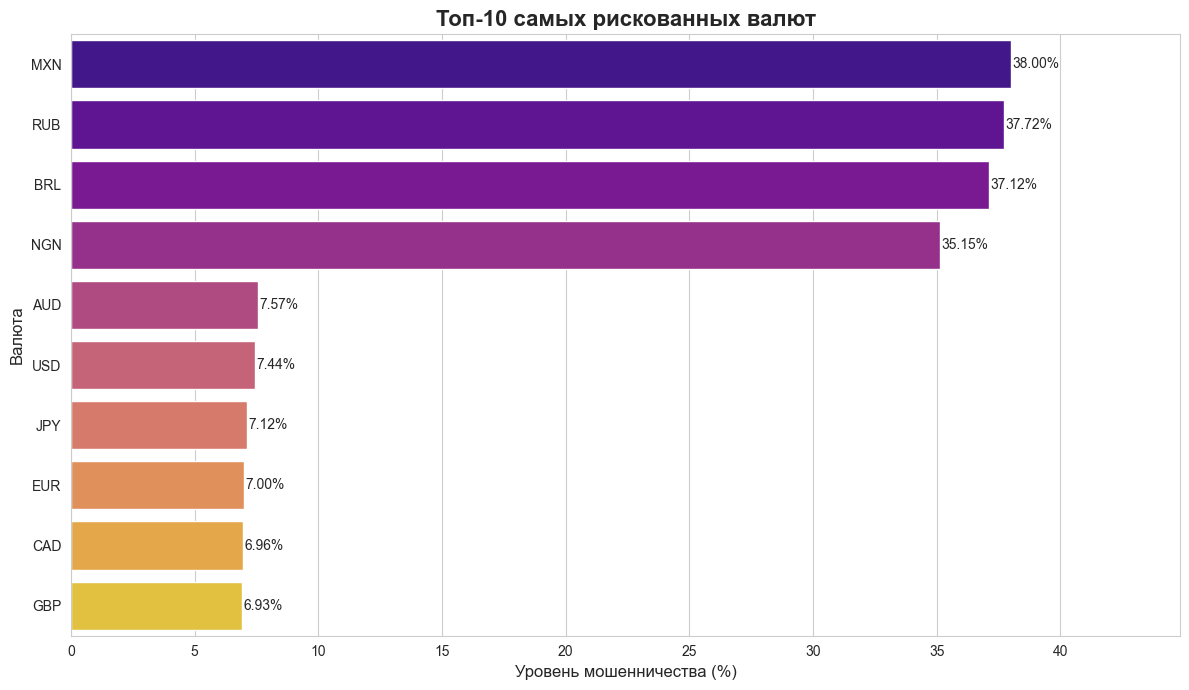

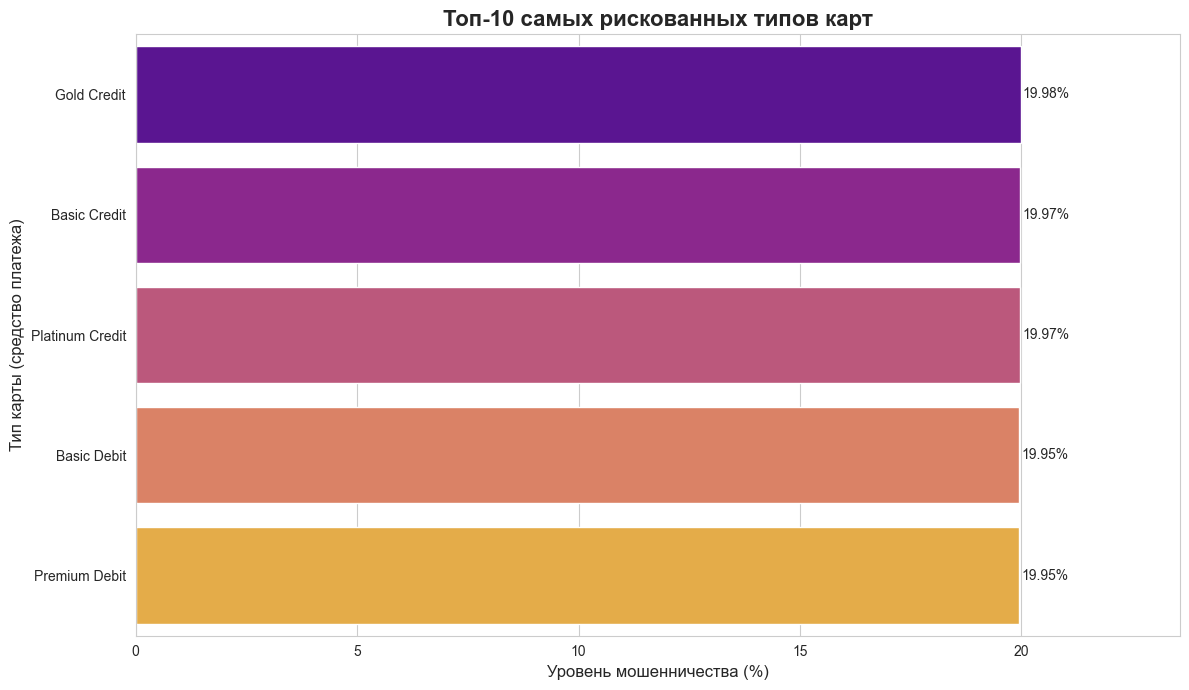

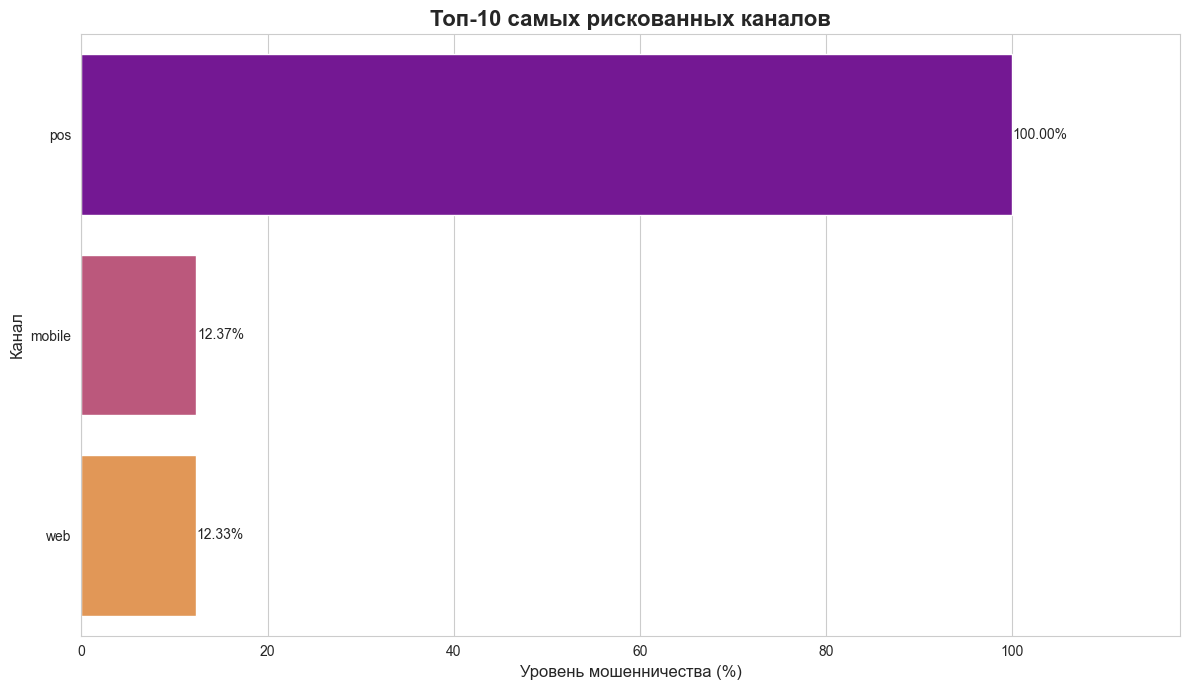

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Настройки для графиков
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 7)

# Загрузка данных
try:
    df = pd.read_parquet('transaction_fraud_data.parquet')
except FileNotFoundError:
    print("Файл 'transaction_fraud_data.parquet' не найден.")
    df = pd.DataFrame()

# Фильтрация данных
safe_vendors_df = df[df['is_high_risk_vendor'] == False].copy()

def analyze_and_plot_risk(dataframe, category_column, top_n=10):
    """
    Анализирует риск по категории и строит график (с обновленным синтаксисом).
    """
    analysis = dataframe.groupby(category_column).agg(
        total_transactions=('transaction_id', 'count'),
        fraud_transactions=('is_fraud', 'sum')
    ).reset_index()
    analysis['fraud_rate'] = (analysis['fraud_transactions'] / analysis['total_transactions']) * 100
    
    top_risky = analysis.sort_values('fraud_rate', ascending=False).head(top_n)

    plt.figure(figsize=(12, 7))
    
    # Мы явно указываем, что цветом (hue) нужно выделить категории с оси Y,
    # и отключаем ненужную в данном случае легенду.
    ax = sns.barplot(
        x='fraud_rate', 
        y=category_column, 
        data=top_risky, 
        orient='h', 
        palette='plasma', 
        hue=category_column,  # Явно указываем, что раскрашивать
        legend=False          # Отключаем дублирующую легенду
    )

    for p in ax.patches:
        width = p.get_width()
        plt.text(width + 0.05, p.get_y() + p.get_height() / 2, f'{width:.2f}%', va='center')

    title_map = {
        'country': 'стран', 'currency': 'валют',
        'card_type': 'типов карт', 'channel': 'каналов'
    }
    category_map = {
        'country': 'Страна', 'currency': 'Валюта',
        'card_type': 'Тип карты (средство платежа)', 'channel': 'Канал'
    }
    
    plt.title(f'Топ-{top_n} самых рискованных {title_map.get(category_column)}', fontsize=16, weight='bold')
    plt.xlabel('Уровень мошенничества (%)', fontsize=12)
    plt.ylabel(category_map.get(category_column), fontsize=12)
    plt.xlim(0, top_risky['fraud_rate'].max() * 1.18)
    plt.tight_layout()
    plt.show()

# --- Запуск для генерации графиков ---
if not df.empty:
    print("Генерация графиков с исправленным кодом:")
    analyze_and_plot_risk(safe_vendors_df, 'country')
    analyze_and_plot_risk(safe_vendors_df, 'currency')
    analyze_and_plot_risk(safe_vendors_df, 'card_type')
    analyze_and_plot_risk(safe_vendors_df, 'channel')

Генерация сравнительных графиков:


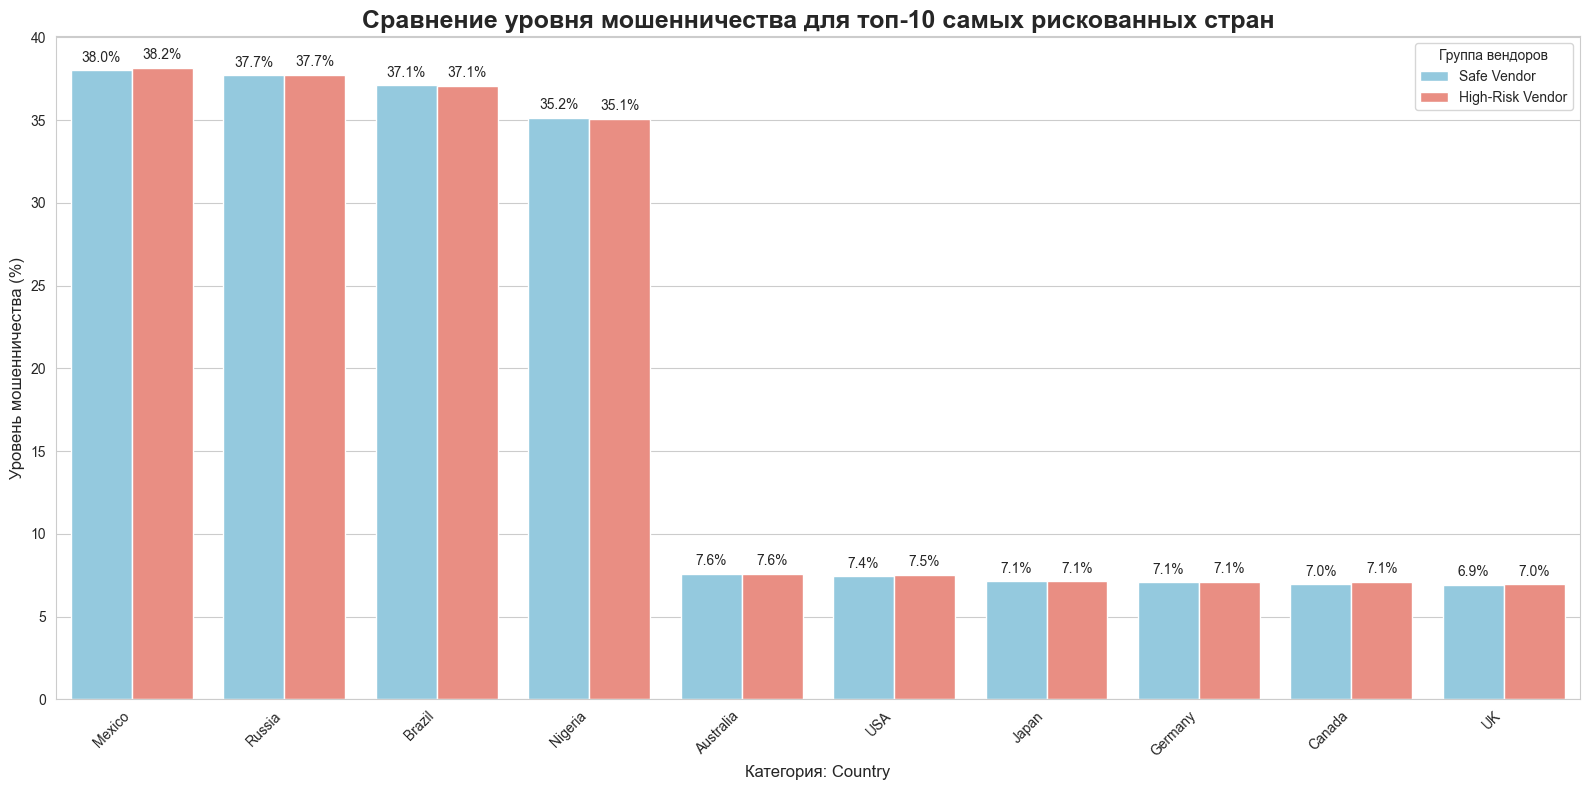

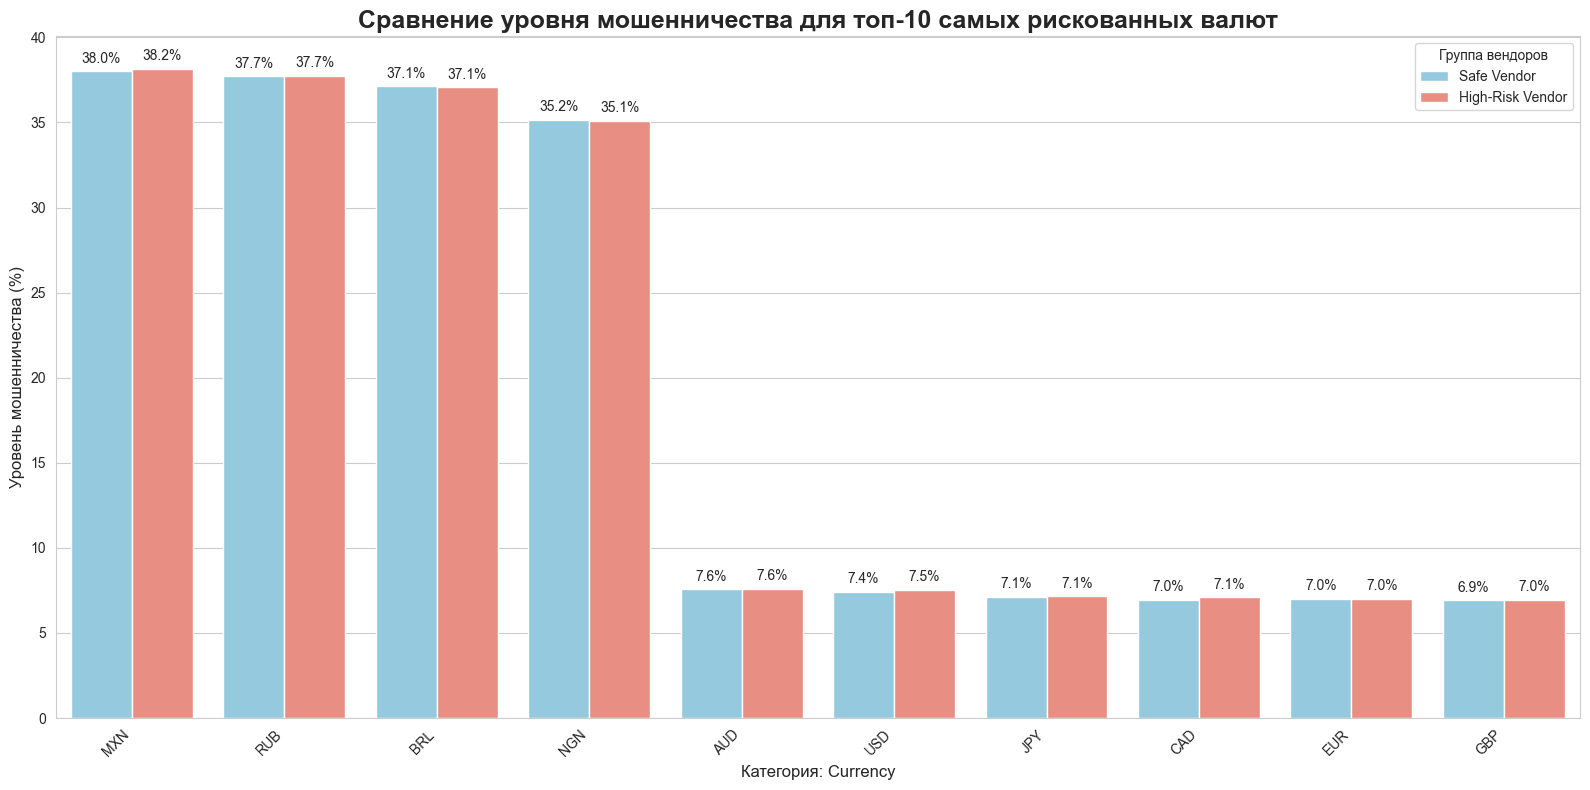

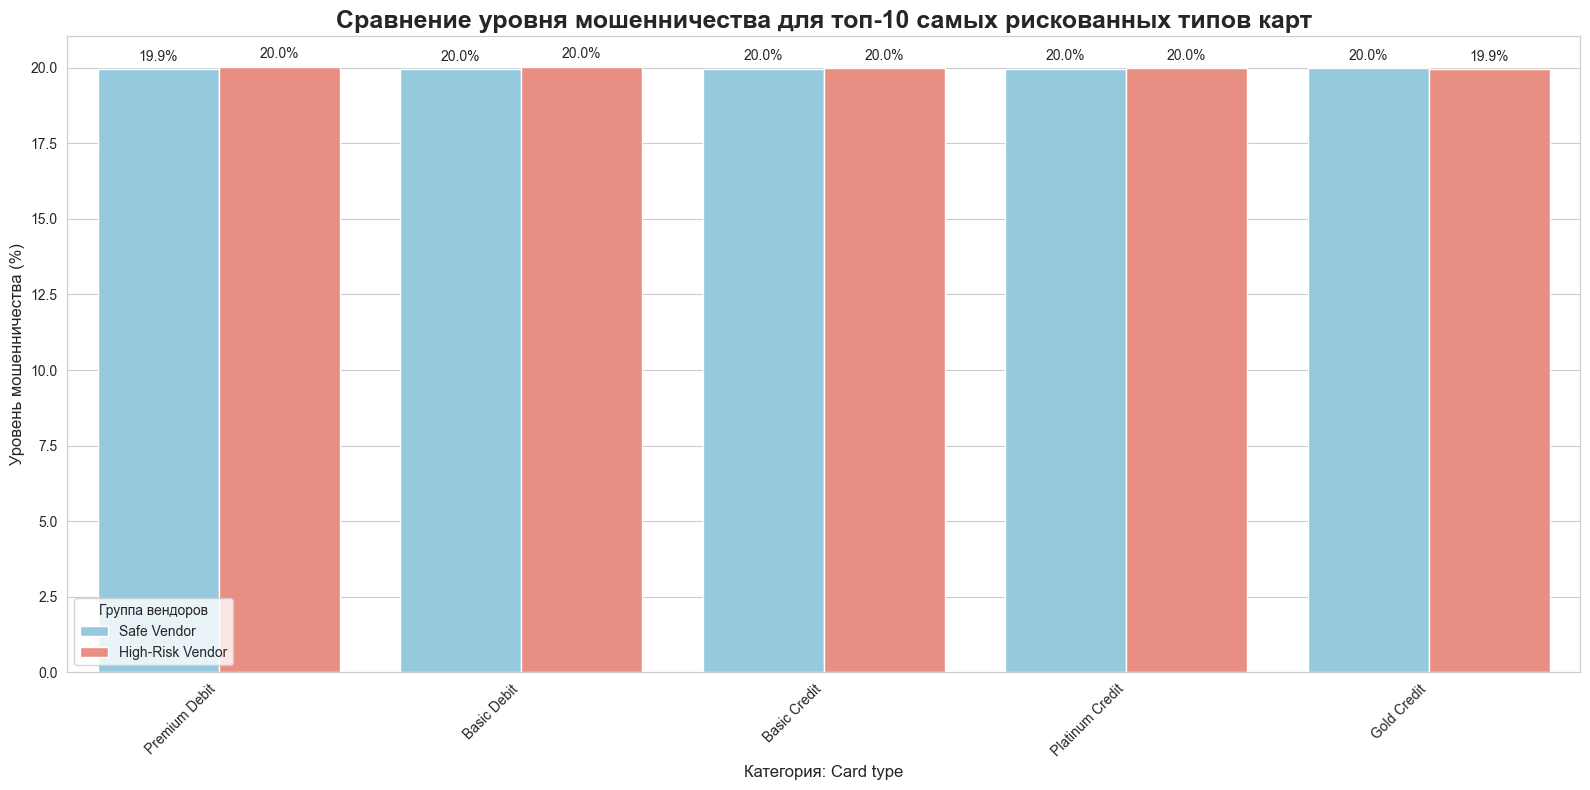

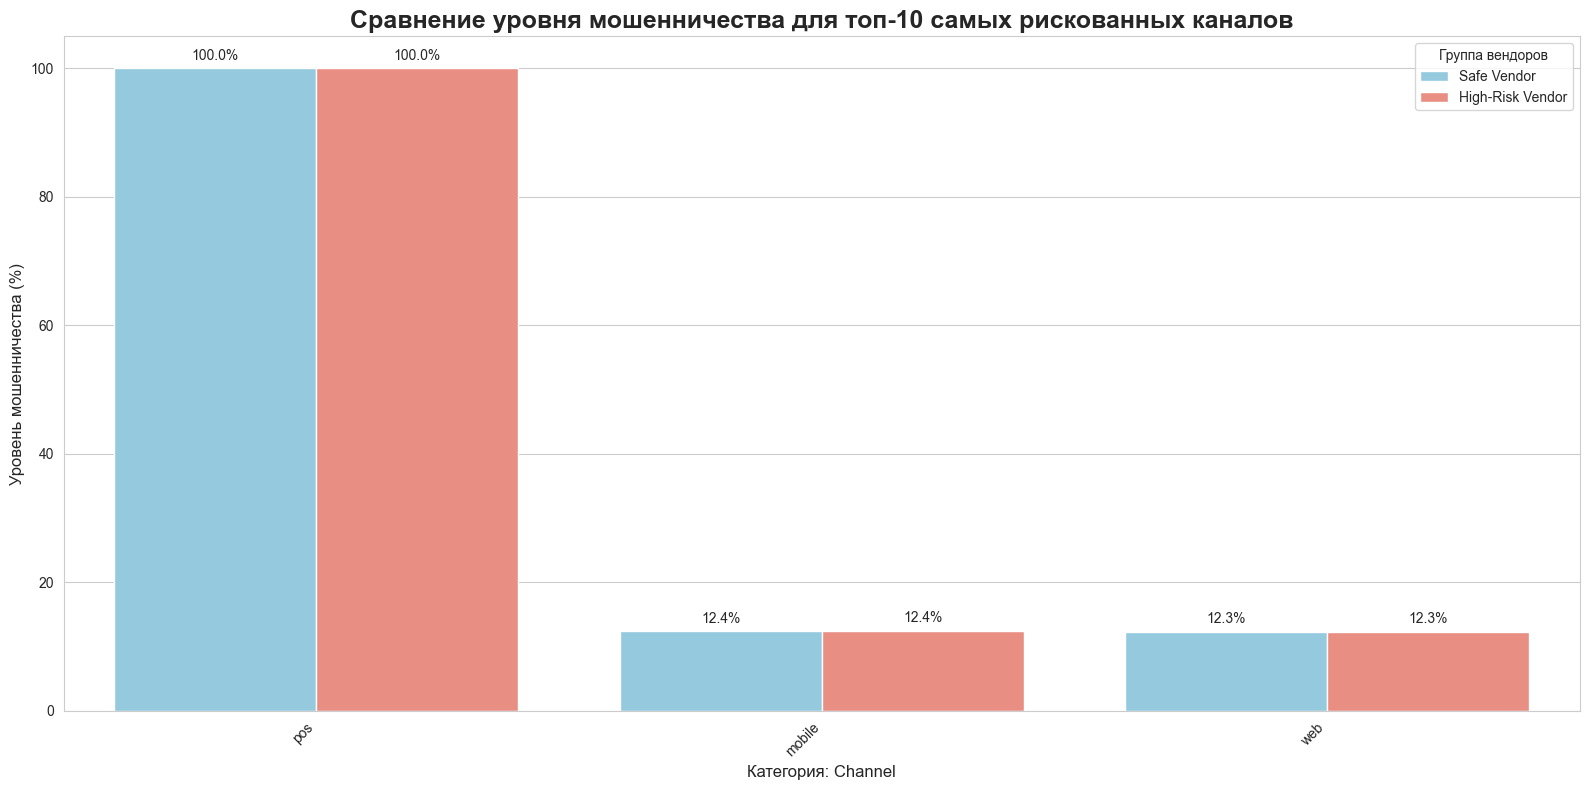

In [2]:
# Настройки для графиков
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (16, 8)

def plot_comparative_risk(df, category_column, top_n=10):
    """
    Строит сравнительный график уровня мошенничества для групп с высоким и низким риском
    по заданной категории.
    """
    if df.empty:
        print(f"DataFrame пуст, невозможно построить график для '{category_column}'.")
        return

    # 1. Расчет уровня мошенничества для каждой группы
    fraud_rates = df.groupby([category_column, 'is_high_risk_vendor'])['is_fraud'].value_counts(normalize=True).unstack(fill_value=0)
    
    # Интересует только доля True (мошенничество)
    if True not in fraud_rates.columns:
        print(f"В категории '{category_column}' нет мошеннических транзакций для анализа.")
        return
        
    fraud_rates = (fraud_rates[True] * 100).unstack(level='is_high_risk_vendor').reset_index()
    fraud_rates.columns = [category_column, 'Safe Vendor', 'High-Risk Vendor']
    fraud_rates = fraud_rates.fillna(0)

    # 2. Определение топ-N категорий по максимальному риску
    fraud_rates['max_risk'] = fraud_rates[['Safe Vendor', 'High-Risk Vendor']].max(axis=1)
    top_categories = fraud_rates.sort_values('max_risk', ascending=False).head(top_n)

    # 3. Подготовка данных для графика (преобразование в "длинный" формат)
    plot_data = pd.melt(
        top_categories,
        id_vars=category_column,
        value_vars=['Safe Vendor', 'High-Risk Vendor'],
        var_name='Vendor Risk Group',
        value_name='Fraud Rate (%)'
    )
    
    # 4. Построение графика
    plt.figure(figsize=(16, 8))
    ax = sns.barplot(
        data=plot_data,
        x=category_column,
        y='Fraud Rate (%)',
        hue='Vendor Risk Group',
        palette={'Safe Vendor': 'skyblue', 'High-Risk Vendor': 'salmon'}
    )
    
    # Добавление подписей к столбикам
    for p in ax.patches:
        if p.get_height() > 0:
            ax.annotate(f'{p.get_height():.1f}%', 
                        (p.get_x() + p.get_width() / 2., p.get_height()), 
                        ha='center', va='center', 
                        xytext=(0, 9), 
                        textcoords='offset points')

    # Настройка названий и меток
    category_map = {
        'country': 'стран', 'currency': 'валют',
        'card_type': 'типов карт', 'channel': 'каналов'
    }
    plt.title(f'Сравнение уровня мошенничества для топ-{top_n} самых рискованных {category_map.get(category_column)}', fontsize=18, weight='bold')
    plt.xlabel(f'Категория: {category_column.replace("_", " ").capitalize()}', fontsize=12)
    plt.ylabel('Уровень мошенничества (%)', fontsize=12)
    plt.xticks(rotation=45, ha='right')
    plt.legend(title='Группа вендоров')
    plt.tight_layout()
    plt.show()

# --- Генерация сравнительных графиков ---
if not df.empty:
    print("Генерация сравнительных графиков:")
    plot_comparative_risk(df, 'country')
    plot_comparative_risk(df, 'currency')
    plot_comparative_risk(df, 'card_type')
    plot_comparative_risk(df, 'channel')